In [1]:
import os
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import random
import torch
import torchio as tio
import matplotlib.pyplot as plt
from dataset_tio import Normalize, ImagePair, RealImage, calculate_overlap, real_data, data_split
import torchvision
from models.generator import GeneratorRRDB
from models.generator_old import GeneratorRRDB as GeneratorRRDB_old
from models.discriminator import Discriminator
from models.feature_extractor import FeatureExtractor

from trainer_org import LitTrainer as LitTrainer_org
from trainer_gan import LitTrainer as LitTrainer_gan
import pytorch_lightning as pl

from torchvision.utils import save_image
from torchsummary import summary
import time
from utils import save_subject, save_subject_all
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import normalized_root_mse as NRSME
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
std = 0.3548
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [4]:
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1)
# generator_old = GeneratorRRDB_old(channels=1, filters=64, num_res_blocks=1)
discriminator = Discriminator(input_shape=(1, 64, 64))
feature_extractor = FeatureExtractor()

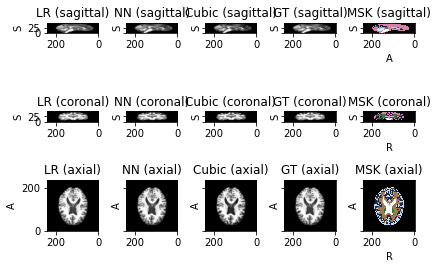

In [5]:
# img_real = RealImage(number=1, select_slices=None)
# real_subject = [img_real.subject()]
# real_set = tio.SubjectsDataset(
#     real_subject, transform=Normalize(std=std))
#
# real_set[0].plot()

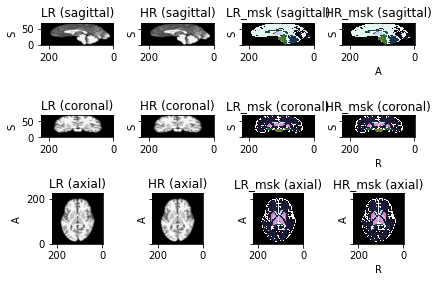

In [53]:
# img_sim = ImagePair(number=100206, select_slices=None, datasource='2mm_1mm')
# sim_subject = [img_sim.subject()]
#
# sim_set = tio.SubjectsDataset(
#     sim_subject, transform=Normalize(std=std))
#
# sim_set[0].plot()

In [5]:
test_subjects = real_data(root_dir='data',
                          numslices=None)
# test_subjects = [test_subjects[0]]

test_set_real = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading real dataset...


In [6]:
test_subjects = data_split('test',
                           patients_frac=1,
                           datasource='2mm_1mm',
                           numslices=None)
# test_subjects = [test_subjects[0]]

test_set_sim = tio.SubjectsDataset(
    test_subjects, transform=Normalize(std=std))

Loading test set...


In [15]:
# source = 'sim'
#
# if source == 'sim':
#     img = sim_set
# elif source == 'real':
#     img = real_set

In [7]:
config_gan = {
    'optimizer': 'adam',
    'b1': 0.9,
    'b2': 0.5,
    'batch_size': 16,
    'num_filters': 64,
    'learning_rate': 1e-4,
    'patch_size': 64,
    'alpha_content': 0,
    'alpha_adversarial': 0.1,
    'ragan': False,
    'gan_mode': 'vanilla',
    'edge_loss': 2,
    'netD_freq': 1,
    'datasource': '2mm_1mm',
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
}

root = '/mnt/beta/djboonstoppel/Code'
exp_name = 'baseline_gan'
version = 0
epoch = 68
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path_gan = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [58]:
# config_gan_content = {
#     'optimizer': 'adam',
#     'b1': 0.9,
#     'b2': 0.5,
#     'batch_size': 16,
#     'num_filters': 64,
#     'learning_rate': 1e-4,
#     'patch_size': 64,
#     'alpha_content': 1,
#     'alpha_adversarial': 0.1,
#     'ragan': False,
#     'gan_mode': 'vanilla',
#     'edge_loss': 2,
#     'netD_freq': 1,
#     'datasource': '2mm_1mm',
#     'patients_frac': 0.5,
#     'patch_overlap': 0.5,
# }
#
# root = '/mnt/beta/djboonstoppel/Code'
# exp_name = 'baseline_gan_content'
# version = 0
# epoch = 69
# ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
# path_gan_content = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

In [8]:
config_bep = {
    'batch_size': 16,
    'num_filters': 64,
    'optimizer': 'adam',
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
    'edge_loss': 2,
    'b1': 0.9,
    'b2': 0.5,
    'alpha_content': 1,
    'learning_rate': 1e-4,
    'patch_size': 64,
    'datasource': '2mm_1mm',
}

root = '/mnt/beta/djboonstoppel/Code'
exp_name = 'baseline_bep'
version = 0
epoch = 65
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path_bep = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)


In [9]:
config_content = {
    'batch_size': 16,
    'num_filters': 64,
    'optimizer': 'adam',
    'patients_frac': 0.5,
    'patch_overlap': 0.5,
    'edge_loss': 2,
    'b1': 0.9,
    'b2': 0.5,
    'alpha_content': 1,
    'learning_rate': 1e-4,
    'patch_size': 64,
    'datasource': '2mm_1mm',

}

root = '/mnt/beta/djboonstoppel/Code'
exp_name = 'baseline_content'
version = 0
epoch = 69
ckpt_fname = '{}-checkpoint-epoch={}.ckpt'.format(exp_name, epoch)
path_content = os.path.join(root, 'log', exp_name, 'version_{}'.format(version), ckpt_fname)

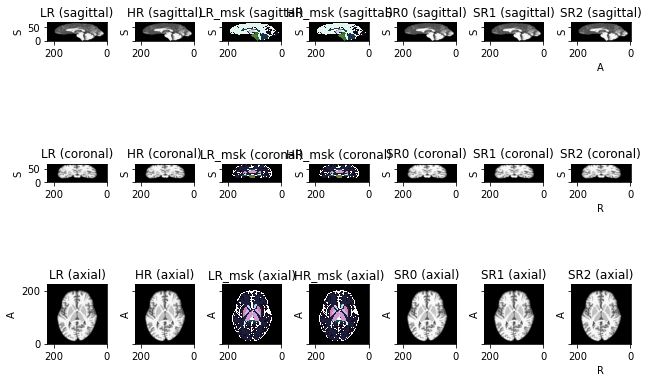

In [27]:
# batch_size = 16
#
# patch_size = (64,64)
# ovl_perc = (.5,.5)
# overlap, nr_patches = calculate_overlap(img[0]['LR'], patch_size, ovl_perc)
#
# subject = img[0]
# grid_sampler = tio.inference.GridSampler(
#     subject,
#     patch_size=(*patch_size,1),
#     patch_overlap=overlap,
#     padding_mode=0,
# )
#
# patch_loader = torch.utils.data.DataLoader(
#     grid_sampler, batch_size=16)
#
# configs = [config_bep, config_content, config_gan]
# paths = [path_bep, path_content, path_gan]
# gan = [False, False, True]
#
# for i in range(len(paths)):
#     if gan[i]:
#         model = LitTrainer_gan.load_from_checkpoint(
#             netG=generator,
#             netF=feature_extractor,
#             netD=discriminator,
#             checkpoint_path=paths[i],
#             config=configs[i]
#         )
#     else:
#         model = LitTrainer_org.load_from_checkpoint(
#             netG=generator,
#             netF=feature_extractor,
#             checkpoint_path=paths[i],
#             config=configs[i]
#         )
#     batch_size = model.hparams.config['batch_size']
#
#     patch_size = (model.hparams.config['patch_size'],model.hparams.config['patch_size'])
#     ovl_perc = (model.hparams.config['patch_overlap'], model.hparams.config['patch_overlap'])
#     overlap, nr_patches = calculate_overlap(img[0]['LR'], patch_size, ovl_perc)
#
#     aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
#     with torch.no_grad():
#         for patches_batch in patch_loader:
#             imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
#             gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
#             locations = patches_batch[tio.LOCATION]
#             aggregator.add_batch(gen_hr, locations)
#
#     foreground = aggregator.get_output_tensor()
#     generated = tio.ScalarImage(tensor=foreground)
#     subject.add_image(generated, 'SR'+str(i))
# subject.plot(figsize=(9, 8))
#

In [190]:
# if source == 'sim':
#     img_source = img_sim
# elif source == 'real':
#     img_source = img_real
#
# fname = 'test'
#
# output_path = os.path.join(root, 'output', 'test2')
# os.makedirs(output_path, exist_ok=True)
# std = std
# max_vals = {
#     'LR': img_source.info()['LR']['scaling'],
#     'HR': img_source.info()['HR']['scaling'],
#     'SR': img_source.info()['LR']['scaling'],
# }
# save_subject_all(subject=subject,
#              header=img_source.info()['LR']['header'],
#              pref=fname,
#              std=std,
#              max_vals=max_vals,
#              path=output_path,
#              source = source,
#              )

LR
HR
SR0
SR1
SR2


In [10]:
def NCC(real_image, generated_image):
    """Method to compute the normalised cross correlation between two images.
    Arguments:
                real_image:       (numpy array) the real image
                predicted_image:  (numpy array) the predicted image by the model
    Returns:
                NCCScore:         (float) the normalised cross correlation score
    """
    # if the images are not the same size, raise an error
    if real_image.shape != generated_image.shape:
        raise AssertionError("The inputs must be the same size.")
    # reshape images to vectors
    u = real_image.reshape((real_image.shape[0]*real_image.shape[1]*real_image.shape[2],1))
    v = generated_image.reshape((generated_image.shape[0]*generated_image.shape[1]*real_image.shape[2],1))
    # take the real image and subtract the mean of the real image
    u = u - u.mean(keepdims=True)
    # take the generated image and subtract the mean of the generated image
    v = v - v.mean(keepdims=True)
    # transpose the real image for multiplication
    TransposedU = np.transpose(u)
    # calculate the length of the image
    length = np.linalg.norm(u,ord=2)*np.linalg.norm(v,ord=2)
    # calculate the NCC of the real image and the generated image
    NCCScore = float(TransposedU.dot(v))/length
    # return the NCC score
    return NCCScore

def get_scores(real, gen):
    ncc = NCC(real, gen)
    ssim = SSIM(real.squeeze(), gen.squeeze(), gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    nrmse = NRSME(real, gen)
    return ncc, ssim, nrmse

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [10:03<00:00, 20.13s/it]


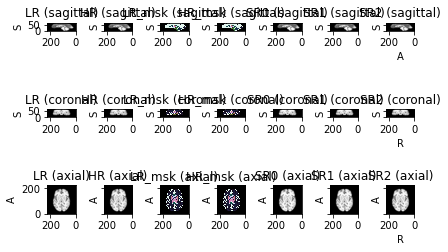

In [11]:
batch_size = 16
patch_size = (64,64)
ovl_perc = (.5,.5)
overlap, nr_patches = calculate_overlap(test_set_sim[0]['LR'], patch_size, ovl_perc)

configs = [config_bep, config_content, config_gan]
paths = [path_bep, path_content, path_gan]
gan = [False, False, True]
test_subjects_new_sim = []
for subject in tqdm(test_set_sim):
    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size=(*patch_size,1),
        patch_overlap=overlap,
        padding_mode=0,
    )

    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=16)

    for i in range(len(paths)):
        if gan[i]:
            model = LitTrainer_gan.load_from_checkpoint(
                netG=generator,
                netF=feature_extractor,
                netD=discriminator,
                checkpoint_path=paths[i],
                config=configs[i]
            )
        else:
            model = LitTrainer_org.load_from_checkpoint(
                netG=generator,
                netF=feature_extractor,
                checkpoint_path=paths[i],
                config=configs[i]
            )

        model.to(device)
        model.eval()

        aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
        with torch.no_grad():
            for patches_batch in patch_loader:
                imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['HR'][tio.DATA].squeeze(4)
                gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
                locations = patches_batch[tio.LOCATION]
                aggregator.add_batch(gen_hr, locations)

        foreground = aggregator.get_output_tensor()
        generated = tio.ScalarImage(tensor=foreground)
        subject.add_image(generated, 'SR'+str(i))
    test_subjects_new_sim.append(subject)
test_subjects_new_sim[0].plot()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:52<00:00, 24.61s/it]


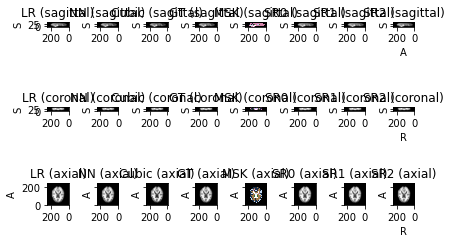

In [12]:
batch_size = 16
patch_size = (64,64)
ovl_perc = (.5,.5)
overlap, nr_patches = calculate_overlap(test_set_real[0]['LR'], patch_size, ovl_perc)

configs = [config_bep, config_content, config_gan]
paths = [path_bep, path_content, path_gan]
gan = [False, False, True]
test_subjects_new_real = []
for subject in tqdm(test_set_real):
    grid_sampler = tio.inference.GridSampler(
        subject,
        patch_size=(*patch_size,1),
        patch_overlap=overlap,
        padding_mode=0,
    )

    patch_loader = torch.utils.data.DataLoader(
        grid_sampler, batch_size=16)

    for i in range(len(paths)):
        if gan[i]:
            model = LitTrainer_gan.load_from_checkpoint(
                netG=generator,
                netF=feature_extractor,
                netD=discriminator,
                checkpoint_path=paths[i],
                config=configs[i]
            )
        else:
            model = LitTrainer_org.load_from_checkpoint(
                netG=generator,
                netF=feature_extractor,
                checkpoint_path=paths[i],
                config=configs[i]
            )

        model.to(device)
        model.eval()

        aggregator = tio.inference.GridAggregator(grid_sampler)#, overlap_mode='average')
        with torch.no_grad():
            for patches_batch in patch_loader:
                imgs_lr, imgs_hr = patches_batch['LR'][tio.DATA].squeeze(4), patches_batch['GT'][tio.DATA].squeeze(4)
                gen_hr = model(imgs_lr.to(device)).unsqueeze(4)
                locations = patches_batch[tio.LOCATION]
                aggregator.add_batch(gen_hr, locations)

        foreground = aggregator.get_output_tensor()
        generated = tio.ScalarImage(tensor=foreground)
        subject.add_image(generated, 'SR'+str(i))
    test_subjects_new_real.append(subject)
test_subjects_new_real[0].plot()


In [33]:
# scores_real = {
#     'NCC': {
#         'NN': [],
#         'Cubic': [],
#         'SR_BEP': [],
#         'SR_Content': [],
#         'SR_GAN': [],
#     },
#     'SSIM': {
#         'NN': [],
#         'Cubic': [],
#         'SR_BEP': [],
#         'SR_Content': [],
#         'SR_GAN': [],
#     },
#     'NRSME': {
#         'NN': [],
#         'Cubic': [],
#         'SR_BEP': [],
#         'SR_Content': [],
#         'SR_GAN': [],
#     },
# }
#
# for i in range(len(test_subjects_new_real)):
#     NN = test_subjects_new_real[i]['NN'].data.squeeze(0)*std
#     CB = test_subjects_new_real[i]['Cubic'].data.squeeze(0)*std
#     GT = test_subjects_new_real[i]['GT'].data.squeeze(0)*std
#     SR_BEP = test_subjects_new_real[i]['SR0'].data.squeeze(0)*std
#     SR_Content = test_subjects_new_real[i]['SR1'].data.squeeze(0)*std
#     SR_GAN = test_subjects_new_real[i]['SR2'].data.squeeze(0)*std
#     ncc_nn, ssim_nn, nrmse_nn = get_scores(GT.numpy(), NN.numpy())
#     ncc_cb, ssim_cb, nrmse_cb = get_scores(GT.numpy(), CB.numpy())
#     ncc_sr_bep, ssim_sr_bep, nrmse_sr_bep = get_scores(GT.numpy(), SR_BEP.numpy())
#     ncc_sr_content, ssim_sr_content, nrmse_sr_content = get_scores(GT.numpy(), SR_Content.numpy())
#     ncc_sr_gan, ssim_sr_gan, nrmse_sr_gan = get_scores(GT.numpy(), SR_GAN.numpy())
#
#     scores_real['NCC']['NN'].append(ncc_nn)
#     scores_real['NCC']['Cubic'].append(ncc_cb)
#     scores_real['NCC']['SR_BEP'].append(ncc_sr_bep)
#     scores_real['NCC']['SR_Content'].append(ncc_sr_content)
#     scores_real['NCC']['SR_GAN'].append(ncc_sr_gan)
#
#     scores_real['SSIM']['NN'].append(ssim_nn)
#     scores_real['SSIM']['Cubic'].append(ssim_cb)
#     scores_real['SSIM']['SR_BEP'].append(ssim_sr_bep)
#     scores_real['SSIM']['SR_Content'].append(ssim_sr_content)
#     scores_real['SSIM']['SR_GAN'].append(ssim_sr_gan)
#
#     scores_real['NRSME']['NN'].append(nrmse_nn)
#     scores_real['NRSME']['Cubic'].append(nrmse_cb)
#     scores_real['NRSME']['SR_BEP'].append(nrmse_sr_bep)
#     scores_real['NRSME']['SR_Content'].append(nrmse_sr_content)
#     scores_real['NRSME']['SR_GAN'].append(nrmse_sr_gan)

In [15]:
scores_real = {
    'NCC': {
        'NN': [],
        'Cubic': [],
        'SR_BEP': [],
        'SR_Content': [],
        'SR_GAN': [],
    },
    'SSIM': {
        'NN': [],
        'Cubic': [],
        'SR_BEP': [],
        'SR_Content': [],
        'SR_GAN': [],
    },
    'NRSME': {
        'NN': [],
        'Cubic': [],
        'SR_BEP': [],
        'SR_Content': [],
        'SR_GAN': [],
    },
}

for i in range(len(test_subjects_new_real)):
    mask = test_subjects_new_real[i]['MSK'].data.squeeze(0)
    x, y, z = np.where(mask!=0)
    x1, x2 = min(x), max(x)+1
    y1, y2 = min(y), max(y)+1
    z1, z2 = min(z), max(z)+1

    NN = test_subjects_new_real[i]['NN'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    CB = test_subjects_new_real[i]['Cubic'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    GT = test_subjects_new_real[i]['GT'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    SR_BEP = test_subjects_new_real[i]['SR0'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    SR_Content = test_subjects_new_real[i]['SR1'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    SR_GAN = test_subjects_new_real[i]['SR2'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    ncc_nn, ssim_nn, nrmse_nn = get_scores(GT.numpy(), NN.numpy())
    ncc_cb, ssim_cb, nrmse_cb = get_scores(GT.numpy(), CB.numpy())
    ncc_sr_bep, ssim_sr_bep, nrmse_sr_bep = get_scores(GT.numpy(), SR_BEP.numpy())
    ncc_sr_content, ssim_sr_content, nrmse_sr_content = get_scores(GT.numpy(), SR_Content.numpy())
    ncc_sr_gan, ssim_sr_gan, nrmse_sr_gan = get_scores(GT.numpy(), SR_GAN.numpy())

    scores_real['NCC']['NN'].append(ncc_nn)
    scores_real['NCC']['Cubic'].append(ncc_cb)
    scores_real['NCC']['SR_BEP'].append(ncc_sr_bep)
    scores_real['NCC']['SR_Content'].append(ncc_sr_content)
    scores_real['NCC']['SR_GAN'].append(ncc_sr_gan)

    scores_real['SSIM']['NN'].append(ssim_nn)
    scores_real['SSIM']['Cubic'].append(ssim_cb)
    scores_real['SSIM']['SR_BEP'].append(ssim_sr_bep)
    scores_real['SSIM']['SR_Content'].append(ssim_sr_content)
    scores_real['SSIM']['SR_GAN'].append(ssim_sr_gan)

    scores_real['NRSME']['NN'].append(nrmse_nn)
    scores_real['NRSME']['Cubic'].append(nrmse_cb)
    scores_real['NRSME']['SR_BEP'].append(nrmse_sr_bep)
    scores_real['NRSME']['SR_Content'].append(nrmse_sr_content)
    scores_real['NRSME']['SR_GAN'].append(nrmse_sr_gan)

In [17]:
scores_simulated = {
    'NCC': {
        'SR_BEP': [],
        'SR_Content': [],
        'SR_GAN': [],
    },
    'SSIM': {
        'SR_BEP': [],
        'SR_Content': [],
        'SR_GAN': [],
    },
    'NRSME': {
        'SR_BEP': [],
        'SR_Content': [],
        'SR_GAN': [],
    },
}

for i in range(len(test_subjects_new_sim)):
    mask = test_subjects_new_sim[i]['HR_msk'].data.squeeze(0)
    x, y, z = np.where(mask!=0)
    x1, x2 = min(x), max(x)+1
    y1, y2 = min(y), max(y)+1
    z1, z2 = min(z), max(z)+1

    HR = test_subjects_new_sim[i]['HR'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    SR_BEP = test_subjects_new_sim[i]['SR0'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    SR_Content = test_subjects_new_sim[i]['SR1'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    SR_GAN = test_subjects_new_sim[i]['SR2'].data.squeeze(0)[x1:x2, y1:y2, z1:z2]*std
    ncc_sr_bep, ssim_sr_bep, nrmse_sr_bep = get_scores(HR.numpy(), SR_BEP.numpy())
    ncc_sr_content, ssim_sr_content, nrmse_sr_content = get_scores(HR.numpy(), SR_Content.numpy())
    ncc_sr_gan, ssim_sr_gan, nrmse_sr_gan = get_scores(HR.numpy(), SR_GAN.numpy())

    scores_simulated['NCC']['SR_BEP'].append(ncc_sr_bep)
    scores_simulated['NCC']['SR_Content'].append(ncc_sr_content)
    scores_simulated['NCC']['SR_GAN'].append(ncc_sr_gan)

    scores_simulated['SSIM']['SR_BEP'].append(ssim_sr_bep)
    scores_simulated['SSIM']['SR_Content'].append(ssim_sr_content)
    scores_simulated['SSIM']['SR_GAN'].append(ssim_sr_gan)

    scores_simulated['NRSME']['SR_BEP'].append(nrmse_sr_bep)
    scores_simulated['NRSME']['SR_Content'].append(nrmse_sr_content)
    scores_simulated['NRSME']['SR_GAN'].append(nrmse_sr_gan)

43 181 16 195 0 65
43 181 15 197 0 65
44 178 23 201 0 69
50 176 17 197 0 65
44 178 21 195 0 67
40 183 21 197 0 67
41 183 15 203 0 71
44 179 19 195 0 69
43 182 17 192 0 67
46 176 14 197 0 68
49 175 27 190 0 62
39 183 14 207 0 72
45 178 22 197 0 65
44 176 13 201 0 68
43 178 19 201 0 73
43 179 19 204 0 68
43 179 18 198 0 67
42 181 13 202 0 71
36 183 15 202 0 68
40 182 7 197 0 67
40 182 12 199 0 68
45 178 13 203 0 67
45 178 24 195 0 68
41 181 17 199 0 65
43 182 27 195 0 67
50 175 26 193 0 67
46 178 25 200 0 68
45 176 12 194 0 66
43 182 14 199 0 71
46 179 11 204 0 71


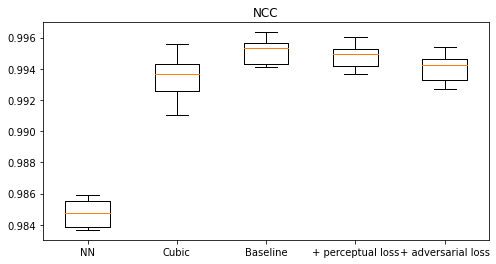

In [18]:
fig, ax = plt.subplots(figsize=[8,4])
fig.set_facecolor('white')
ax.set_title('NCC')
ax.boxplot(scores_real['NCC'].values(), showfliers=False)
ax.set_xticklabels(['NN', 'Cubic', 'Baseline', '+ perceptual loss', '+ adversarial loss'])
fig.savefig('figs/Real_NCC_v2', dpi=240)

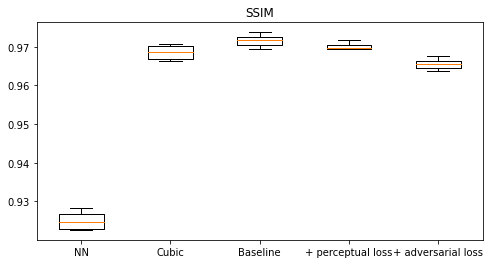

In [19]:
fig, ax = plt.subplots(figsize=[8,4])
fig.set_facecolor('white')
ax.set_title('SSIM')
ax.boxplot(scores_real['SSIM'].values(), showfliers=False)
ax.set_xticklabels(['NN', 'Cubic', 'Baseline', '+ perceptual loss', '+ adversarial loss'])
fig.savefig('figs/Real_SSIM_v2', dpi=240)

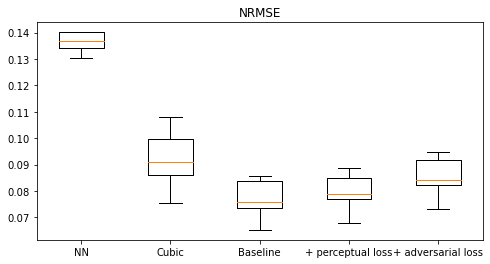

In [21]:
fig, ax = plt.subplots(figsize=[8,4])
fig.set_facecolor('white')
ax.set_title('NRMSE')
ax.boxplot(scores_real['NRSME'].values(), showfliers=False)
ax.set_xticklabels(['NN', 'Cubic', 'Baseline', '+ perceptual loss', '+ adversarial loss'])
fig.savefig('figs/Real_NRMSE_v2', dpi=240)

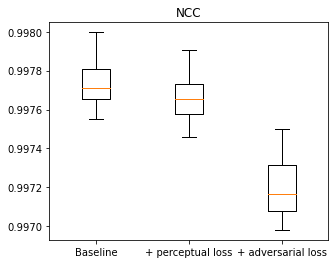

In [22]:
fig, ax = plt.subplots(figsize=[5,4])
fig.set_facecolor('white')
ax.set_title('NCC')
ax.boxplot(scores_simulated['NCC'].values(), showfliers=False)
ax.set_xticklabels(['Baseline', '+ perceptual loss', '+ adversarial loss'])
fig.savefig('figs/Sim_NCC_v2', dpi=240)

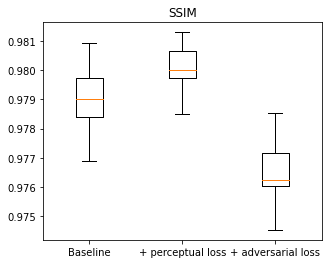

In [23]:
fig, ax = plt.subplots(figsize=[5,4])
fig.set_facecolor('white')
ax.set_title('SSIM')
ax.boxplot(scores_simulated['SSIM'].values(), showfliers=False)
ax.set_xticklabels(['Baseline', '+ perceptual loss', '+ adversarial loss'])
fig.savefig('figs/Sim_SSIM_v2', dpi=240)

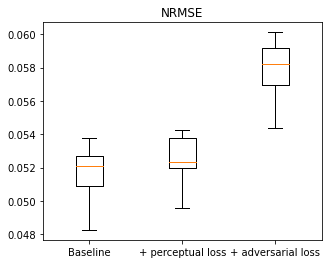

In [25]:
fig, ax = plt.subplots(figsize=[5,4])
fig.set_facecolor('white')
ax.set_title('NRMSE')
ax.boxplot(scores_simulated['NRSME'].values(), showfliers=False)
ax.set_xticklabels(['Baseline', '+ perceptual loss', '+ adversarial loss'])
fig.savefig('figs/Sim_NRMSE_v2', dpi=240)

In [50]:
img_slice0 = test_subjects_new_sim[0]['SR0'].data[0,:,:,15].numpy()*std
img_slice1 = test_subjects_new_sim[0]['SR1'].data[0,:,:,15].numpy()*std
img_slice2 = test_subjects_new_sim[0]['SR2'].data[0,:,:,15].numpy()*std

fig, axes = plt.subplots(1,3, figsize=[10,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1, img_slice2]
titles = ['Baseline', '+ perceptual loss', '+ adversarial loss']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 90, 130

    axis.imshow(np.pad(imgs[i], (0,50), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i],cmap='gray')#, interpolation='bicubic')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# plt.draw()
# plt.show()
fig.savefig('figs/Sim_results_test.png', dpi=300, bbox_inches='tight')

NameError: name 'test_subjects_new_sim' is not defined

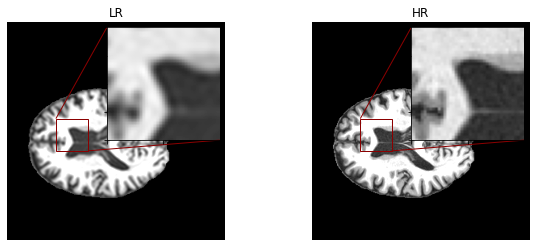

In [59]:
img_slice0 = test_subjects_new_real[0]['LR'].data[0,:,:,15].numpy()*std
img_slice1 = test_subjects_new_real[0]['GT'].data[0,:,:,15].numpy()*std

fig, axes = plt.subplots(1,2, figsize=[10,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1]
titles = ['LR', 'HR']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 110, 150

    axis.imshow(np.pad(imgs[i], (0,30), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i],cmap='gray')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
fig.savefig('figs/Real_org', dpi=300, bbox_inches='tight')

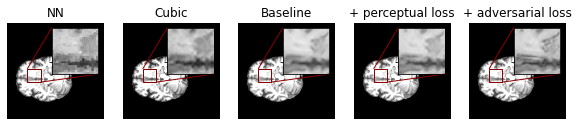

In [52]:
img_slice0 = test_subjects_new_real[0]['NN'].data[0,:,:,15].numpy()*std
img_slice1 = test_subjects_new_real[0]['Cubic'].data[0,:,:,15].numpy()*std
img_slice2 = test_subjects_new_real[0]['SR0'].data[0,:,:,15].numpy()*std
img_slice3 = test_subjects_new_real[0]['SR1'].data[0,:,:,15].numpy()*std
img_slice4 = test_subjects_new_real[0]['SR2'].data[0,:,:,15].numpy()*std

fig, axes = plt.subplots(1,5, figsize=[10,4])
fig.set_facecolor('white')
imgs = [img_slice0, img_slice1, img_slice2, img_slice3, img_slice4]
titles = ['NN', 'Cubic', 'Baseline', '+ perceptual loss', '+ adversarial loss']
for i, axis in enumerate(axes):
    axis.set_axis_off()
    axis.set_title(titles[i])
    x1, x2, y1, y2 = 60, 100, 110, 150

    axis.imshow(np.pad(imgs[i], (0,50), 'edge'), origin="lower", cmap='gray', vmin=0, vmax=1)
    axins = zoomed_inset_axes(axis, 3.5, loc=1) # zoom = 3.5
    axins.imshow(imgs[i],cmap='gray')#, interpolation='bicubic')
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(axis, axins, loc1=2, loc2=4, fc="none", ec='darkred', lw=1)
# plt.draw()
# plt.show()
fig.savefig('figs/Real_results.png', dpi=300, bbox_inches='tight')